Project: Data-Backed PRD for a "QuickPay Hub" Feature





Executive Summary
Problem: Users who make frequent, low-value payments to the same merchants (e.g., daily coffee, canteen lunch) experience significant friction in the standard, multi-step payment process.

Analysis: To validate this problem, a large-scale public retail dataset was used as a behavioral proxy. Analysis using SQL and Python revealed a distinct power-user segment that makes high-frequency, repetitive purchases of the same items. However, a deeper analysis showed that the transaction values for these items often varied, providing a crucial insight.

Solution: Based on this data, we pivoted from a rigid, fixed-amount widget to a more flexible "QuickPay Hub." This feature allows users to save favorite merchants for a one-tap payment initiation, pre-filling the receiver's details but allowing for variable amounts. This design directly addresses the core user need for speed and convenience in a more scalable and realistic way.

Note on Data: This analysis uses a public retail dataset as a behavioral proxy. A future analysis with internal fintech transaction data would be required to further validate these findings at scale.

In [25]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset using the required encoding
try:
    df = pd.read_csv('retail_data.csv', encoding='latin1')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: Make sure the file 'retail_data.csv' is in the same folder as your notebook.")

Dataset loaded successfully!


Part 1: Data Cleaning & Preparation
Objective: The first step is to clean the raw data to ensure our analysis is accurate. Our process involves:

Removing transactions without a CustomerID, as we cannot analyze user behavior without a user ID.

Removing "returns" (transactions with a negative quantity) to focus solely on purchases.

Creating a TotalPrice column for easier analysis.



In [31]:
# Drop rows where CustomerID is missing
df.dropna(subset=['CustomerID'], inplace=True)

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Remove returns (negative quantity)
df = df[df['Quantity'] > 0]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# # --- NEW STEP: Remove Carriage Fee ---
# # Based on our exploration, 'C2' is the StockCode for CARRIAGE.
# df_products_only = df[df['StockCode'] != 'C2'].copy()

print("Data cleaning complete. Analysis will be performed on product-only transactions.")

Data cleaning complete. Analysis will be performed on product-only transactions.


Crucially, we will remove the "Carriage" or shipping fee transactions. This is to ensure our analysis focuses on genuine user product choices, not business artifacts.

In [33]:
# Based on the analysis above, we identify 'C2' (Carriage) as a business artifact.
# We create a new DataFrame excluding this item to focus on real product choices.
df_products_only = df[df['StockCode'] != 'C2'].copy()

print("\n'Carriage' item (StockCode: C2) removed. Proceeding with refined analysis.")


'Carriage' item (StockCode: C2) removed. Proceeding with refined analysis.


Part 2: Identifying Power-User Behavior with SQL
Hypothesis: A segment of users makes a high number of repeat purchases of the same items.

Method: To test this, I will use an SQL query to group all transactions by CustomerID and StockCode and count the occurrences. This will allow us to identify and quantify the most frequent customer-product pairs.

In [27]:
# Define a function for running SQL queries on our DataFrame
pysqldf = lambda q: sqldf(q, globals())

# SQL query to find the most frequent customer-item pairs
sql_query = """
SELECT
    CustomerID,
    StockCode,
    COUNT(*) as purchase_count
FROM
    df_products_only
GROUP BY
    CustomerID, StockCode
HAVING
    COUNT(*) > 5
ORDER BY
    purchase_count DESC
LIMIT 10;
"""

# Execute the query
top_frequent_pairs_sql = pysqldf(sql_query)

print("Top 10 most frequent pairs (found using SQL):")
print(top_frequent_pairs_sql)

Top 10 most frequent pairs (found using SQL):
   CustomerID StockCode  purchase_count
0       17841     79321              64
1       17841     21975              54
2       14911     22423              51
3       17841     21927              49
4       17841     22355              48
5       17841     22467              47
6       17841     22475              42
7       17841     21935              40
8       17841     47421              40
9       17841     21672              39


Part 3: Visualizing the Findings
Objective: To better understand the distribution of customer loyalty and visualize the behavior of a power user.

Chart 1: Distribution of Repeat Purchases
This histogram will show us the "long tail" of customer loyalty.

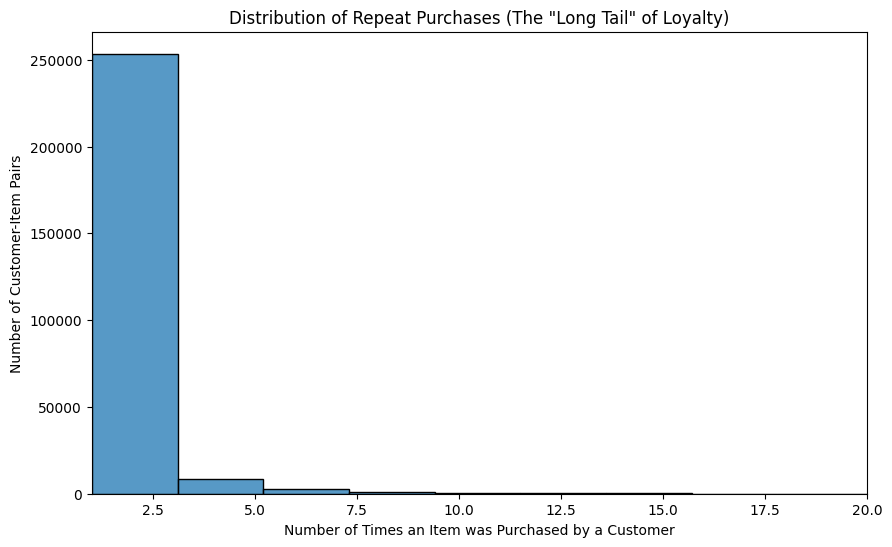

In [28]:
# Get the full list of purchase counts for the chart
purchase_counts = df_products_only.groupby(['CustomerID', 'StockCode']).size().reset_index(name='purchase_count')

plt.figure(figsize=(10, 6))
sns.histplot(purchase_counts['purchase_count'], bins=30, kde=False)
plt.title('Distribution of Repeat Purchases (The "Long Tail" of Loyalty)')
plt.xlabel('Number of Times an Item was Purchased by a Customer')
plt.ylabel('Number of Customer-Item Pairs')
plt.xlim(1, 20)
plt.show()

Insight from Chart 1: The chart clearly shows a "long tail" pattern. While most repeat behavior involves 2-5 purchases, a valuable segment of power users exists who purchase items far more frequently. Our feature is designed to super-serve these high-value users.

Chart 2: Deep-Dive into a Power User's Timeline
Now, let's zoom in on our top power user and visualize their purchase timeline to confirm their high-frequency behavior.

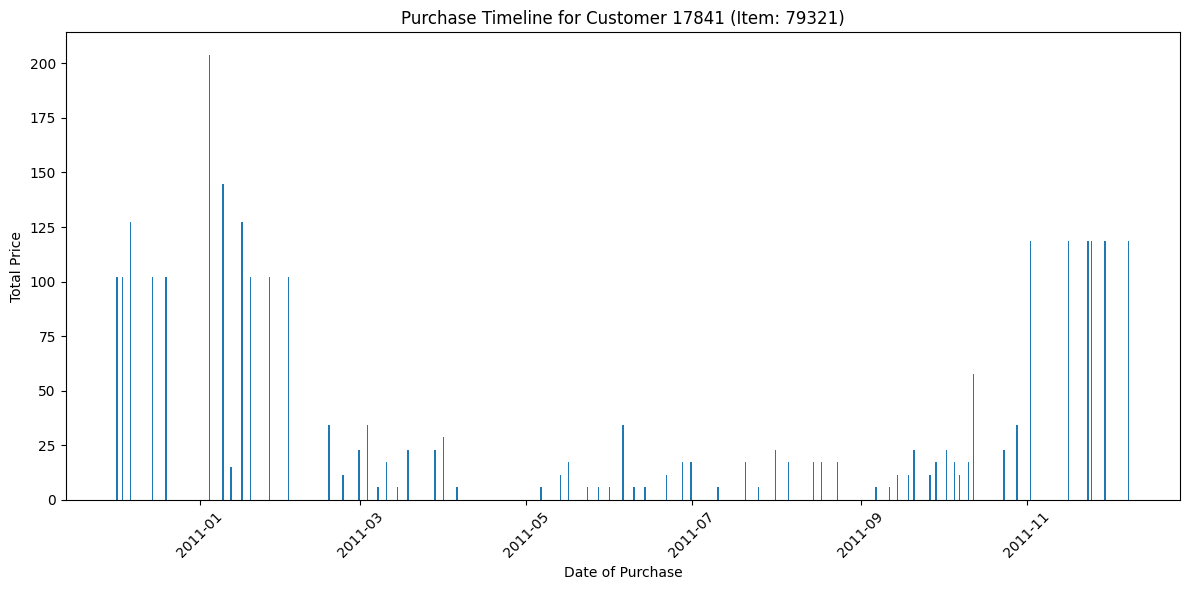

In [29]:
# --- Pick the top user from the SQL query output ---
target_customer_id = top_frequent_pairs_sql['CustomerID'].iloc[0]
target_stock_code = top_frequent_pairs_sql['StockCode'].iloc[0]
# ----------------------------------------------------

# Filter the DataFrame and create a copy to avoid warnings
single_user_history = df_products_only[
    (df_products_only['CustomerID'] == target_customer_id) &
    (df_products_only['StockCode'] == target_stock_code)
].copy()

# Convert InvoiceDate to datetime
single_user_history['InvoiceDate'] = pd.to_datetime(single_user_history['InvoiceDate'])

plt.figure(figsize=(12, 6))
plt.bar(single_user_history['InvoiceDate'], single_user_history['TotalPrice'], width=0.5)
plt.title(f'Purchase Timeline for Customer {target_customer_id} (Item: {target_stock_code})')
plt.xlabel('Date of Purchase')
plt.ylabel('Total Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Part 4: The Final, Crucial Insight - Analyzing Price Consistency
Objective: My initial hypothesis assumed these frequent payments were also for a fixed value. The data will now be used to confirm or deny this.

In [30]:
# Get summary statistics for the 'TotalPrice' column
price_consistency = single_user_history['TotalPrice'].describe()

print(f"Found {len(single_user_history)} purchases for Customer {target_customer_id} buying item {target_stock_code}.")
print("\nPrice Consistency Analysis:")
print(price_consistency)

Found 64 purchases for Customer 17841 buying item 79321.

Price Consistency Analysis:
count     64.000000
mean      43.725000
std       48.457813
min        5.750000
25%       11.500000
50%       17.250000
75%      102.000000
max      204.000000
Name: TotalPrice, dtype: float64


Final Conclusion & Product Pivot
Insight: The analysis of price consistency revealed a crucial, nuanced user behavior. While users purchase the same item repeatedly, the transaction value often varies, as shown by the high standard deviation in the deep-dive analysis.

Product Decision: This insight invalidates the idea of a simple, fixed-amount widget. Therefore, the product strategy was pivoted to the more flexible "QuickPay Hub." This feature addresses the core need for speed by pre-filling merchant details while still allowing the user to input a variable amount, perfectly aligning the product solution with the real-world user behavior discovered in the data.